<a href="https://colab.research.google.com/github/evk2103/fontanka_parsing/blob/main/scraping_NLP_bootcamp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Скрапинг и парсинг данных с сайта
В данном ноутбуке будем собирать данные с новостного сайта fontanka.ru.

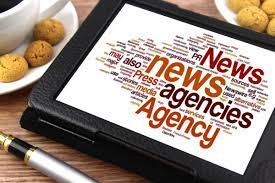

Собирать и парсить будем следующие данные:


* url - url-ссылка на новость
* title - заголовок новости
* timestamp - дата и время новости
* topic - тег новости
* content - текст новости
* views - количество просмотров новости
* coments - количество комментариев к новости




In [1]:
import requests
from bs4 import BeautifulSoup
import re
from datetime import datetime, date, timedelta

import pandas as pd
import numpy as np

from tqdm.notebook import tqdm
import time

Напишем функцию для получения html-страницы. Так как сайт блокирует массовое скачивание страниц, подменим user-агента.

In [ ]:
def get_pages(url):
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/111.0.0.0 Safari/537.36'}
    response = requests.get(url, headers=headers)
    tree = BeautifulSoup(response.content, 'html.parser')
    return tree

Функция для парсинга страницы со списком новостей за определенную дату. В функцию будем передавать дату начала и дату конца для скачивания новостей.
Обратите внимание: наименования классов на сайте часто меняются (примерно раз в сутки), поэтому перед запуском функции необходимо проверить актуальные наименования классов.

In [ ]:
def parse_page(start_date=date(2023, 10, 15), end_date=date(2023, 10, 17)):
    random_seconds = [2, 3, 4]
    info = []

    for delta in tqdm(range((end_date - start_date).days)):
        day_date = (start_date + timedelta(days=delta)).strftime('%Y/%m/%d') # приводим дату к строковому представлению

        time.sleep(np.random.choice(random_seconds))
        url = f'https://www.fontanka.ru/{day_date}/all.html' # формируем url-ссылку для конкретной даты
        tree = get_pages(url)
        news = tree.find_all('li', {'class' : 'KXak5'}) # получаем список со всеми новостями со страницы
        for new in news:
            url = 'https://www.fontanka.ru' + new.find_all('a', {'class' : 'KXb1'})[0].get('href') # получаем url-ссылку по конкретной новости
            title = new.find('a', {'class' : 'KXb1'}).text # получаем текст заголовка новости
            timestamp = datetime.strptime(day_date + ' ' + new.find('span').text, '%Y/%m/%d %H:%M') # получаем время новости, присоединяем дату и переводим в формат datetime
            if new.find_all('a', {'class' : 'L9c3 L9acx KXc3'}): # получаем количество комментариев, если данных нет заполняем нулем
                comments = int(re.findall(r'\d+', new.find_all('a', {'class' : 'L9c3 L9acx KXc3'})[0].get('title'))[0])
            else:
                comments = 0

            if new.find('a', {'class' : 'KXgf KXalj'}): # получаем тег новости
                topic = new.find('a', {'class' : 'KXgf KXalj'}).text
            else:
                topic = None

            row = {
                'url': url,
                'title': title,
                'timestamp': timestamp,
                'comments': comments,
                'topic': topic
                }

            info.append(row)

        if delta % 10 == 0: # на всякий случай сохраняем промежуточные данные
            df = pd.DataFrame(info)
            df.to_csv('fontanka_news.csv', index=False)

    return info

In [ ]:
# скачиваем и парсим новости за 2023 год
info = parse_page(start_date=date(2023, 1, 1), end_date=date(2023, 10, 17))

In [ ]:
# перводим данные в DataFrame и сохраняем в csv-файл
df = pd.DataFrame(info)
df.to_csv('fontanka_news.csv', index=False)

Открываем сохраненный файл, удаляем дубли и сортируем по дате.

In [45]:
data = pd.read_csv('/content/drive/MyDrive/Data/fontanka_news.csv')
data.drop_duplicates(inplace=True)
data.drop_duplicates(subset='url', keep='last', inplace=True)
data.sort_values(by=['timestamp'], inplace=True)

In [46]:
# корректируем url, так как в некоторых случаях на html-странице был указан полный url-адрес
data['url'] = data['url'].apply(lambda x: x[23:] if x.count('https:') > 1 else x)

Теперь скачаем текст и количество просмотров по каждой новости. Для этого напишем функцию, принимающую список url-ссылок на новости

In [ ]:
def parse_views_content(data):
  info = []
  for i, url in enumerate(tqdm(data)):
    try:
      tree = get_pages(url)
      views = int(tree.find('span', {'class' : 'A7gr primaryOverlineMobile'}).text)
      content = tree.find('section', {'class' : 'AJej'}).text
    except:
      views = None
      content = None

    row = {
        'url': url,
        'views': views,
        'content': content
        }

    info.append(row)
    if i % 10 == 0:
      df = pd.DataFrame(info)
      df.to_csv('fontanka_content.csv', index=False)

  return info

In [ ]:
contents1 = parse_views_content(data.url.values[20001:25961]) # запускаем функцию, тут уже закачиваем и парсим остаток, т.к. было прерывание

  0%|          | 0/5960 [00:00<?, ?it/s]

Данные скачиваются довольно долго: на все данные с 01.01.23 по 16.10.23 требутся не менее 13 часов. Так как Googl Colab прерывает скачивание или может быть прерывание со тороны сервера, рекомендую скачивать частями.

In [ ]:
df_content = pd.DataFrame(contents1)

In [ ]:
df_content

,url,views,content
0,https://www.fontanka.ru/2023/08/12/72591476/,36148.0,Фото: Adobe StockПоделитьсяСначала дескриптор:...
1,https://www.fontanka.ru/2023/08/12/72593906/,16889.0,Головокружительную фотографию сделал мужчина с...
2,https://www.fontanka.ru/2023/08/12/72593969/,3870.0,Атаки Украины на Крымский мост не останутся бе...
3,https://www.fontanka.ru/2023/08/12/72593990/,4854.0,"В России наблюдаются сбои в работе Google, сле..."
4,https://www.fontanka.ru/2023/08/10/72586148/,4784.0,Фото: Предоставлено пресс-службой компании «Га...
...,...,...,...
5955,https://doctorpiter.ru/obraz-zhizni/eti-privyc...,NaN,None
5956,https://www.fontanka.ru/2023/10/16/72816851/,15294.0,Министерство иностранных дел Японии призвало Р...
5957,https://www.fontanka.ru/2023/10/16/72816866/,6481.0,"В Брюсселе, где сегодня проходит матч отборочн..."
5958,https://www.fontanka.ru/2023/10/16/72815813/,29551.0,"Ленинградский зоопарк показал, как обедает их ..."


In [ ]:
df_content.to_csv('fontanka_content.csv', index=False) # сохраняем остаток скаченных данных

теперь откроем и соединим все промежуточные файлы и удалим дубликаты

In [6]:
df_content = pd.read_csv('/content/drive/MyDrive/Data/fontanka_content.csv')

In [15]:
for i in range(1,15):
  df = pd.read_csv(f'/content/drive/MyDrive/Data/fontanka_content({i}).csv')
  df_content = pd.concat([df_content, df], ignore_index=True)

df_content.drop_duplicates(subset='url', keep='last', inplace=True)

In [52]:
df_content.reset_index(drop=True, inplace=True)
data.reset_index(drop=True, inplace=True)

In [58]:
df_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25029 entries, 0 to 25028
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   url      25029 non-null  object 
 1   views    22772 non-null  float64
 2   content  22772 non-null  object 
dtypes: float64(1), object(2)
memory usage: 586.7+ KB


In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25341 entries, 0 to 25340
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   url        25341 non-null  object
 1   title      25341 non-null  object
 2   timestamp  25341 non-null  object
 3   comments   25341 non-null  int64 
 4   topic      25116 non-null  object
dtypes: int64(1), object(4)
memory usage: 990.0+ KB


количество строк в датасетах не совпадает. Посмотрим на непересекающиеся url

In [31]:
np.setxor1d(data.url, df_content.url)

array(['h'], dtype=object)

In [59]:
df_content[df_content.url == 'h']

,url,views,content
4796,h,NaN,NaN


In [60]:
df_content.drop(index=4796, inplace=True) # удаляем строку с ошибкой

In [61]:
len(data.url.unique()), len(df_content.url.unique()) # проверяем совпадает ли количество уникальных url в обеих таблицах

(25028, 25028)

In [62]:
# еще раз удаляем дубли
df_content.drop_duplicates(subset='url', keep='last', inplace=True)
data.drop_duplicates(subset='url', keep='last', inplace=True)

In [63]:
df_content.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25028 entries, 0 to 25028
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   url      25028 non-null  object 
 1   views    22772 non-null  float64
 2   content  22772 non-null  object 
dtypes: float64(1), object(2)
memory usage: 782.1+ KB


In [64]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25028 entries, 0 to 25340
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   url        25028 non-null  object
 1   title      25028 non-null  object
 2   timestamp  25028 non-null  object
 3   comments   25028 non-null  int64 
 4   topic      24803 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.1+ MB


теперь количество строк совпадает, можно конкатенировать таблицы.
но сначала посмотрим на пропуски в таблице data в колонке topic

In [68]:
data[pd.isna(data.topic)]

,url,title,timestamp,comments,topic
235,https://www.fontanka.ru/2023/01/04/71952710/,В Госдуме оценили вероятность второй волны моб...,2023-01-04 18:00:00,1,NaN
308,https://www.fontanka.ru/2023/01/05/71953703/,Россия объявила рождественское перемирие — Укр...,2023-01-05 18:00:00,3,NaN
364,https://www.fontanka.ru/2023/01/06/71954402/,"В Минобороны заявили, что Украина не соблюдает...",2023-01-06 18:00:00,5,NaN
427,https://www.fontanka.ru/2023/01/07/71955515/,Зеленский ввел санкции против 119 российских и...,2023-01-07 18:00:00,1,NaN
475,https://www.fontanka.ru/2023/01/08/71956772/,В Минобороны рассказали об операции возмездия ...,2023-01-08 18:00:00,13,NaN
...,...,...,...,...,...
24983,https://www.fontanka.ru/2023/10/12/72803309/,Международный олимпийский комитет отстранил Ро...,2023-10-12 20:05:00,10,NaN
25085,https://www.fontanka.ru/2023/10/13/72808604/,Контрнаступление Украины объявили законченным:...,2023-10-13 20:05:00,57,NaN
25171,https://www.fontanka.ru/2023/10/14/72811550/,"12 новых иноагентов, обстрелы, ремонт Крымског...",2023-10-14 20:25:00,43,NaN
25232,https://www.fontanka.ru/2023/10/15/72812822/,Путин оценил контрнаступление Украины и ход сп...,2023-10-15 20:45:00,65,NaN


Проверка на сайте показала, что эти новости относятся в тегу "Спецоперация на Украине". Заполним пропуски этим тегом

In [ ]:
data['topic'].fillna('Спецоперация на Украине', inplace=True)

Сохраним предобработанные данные обеих таблиц в файлы

In [ ]:
df_content.to_csv('fontanka_content_full.csv', index=False)
data.to_csv('fontanka_news_full.csv', index=False)

In [ ]:
df_full = data.merge(df_content) # соединяем обе таблицы в одну по колонке 'url'

In [ ]:
df_full.to_csv('fontanka_full.csv', index=False) # сохраняем итоговую таблицу в отдельный файл